__Alireza Akbari__<br>
__95105379__

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!cp -r "/content/drive/My Drive/data" .

## Imports

In [81]:
!rm -rf data/crop

In [106]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import os
from crop import *
import cv2
from resnet import *
from dataset import *


# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Config

In [107]:
resize_size = (224, 224)
test_size = 0.2
val_size = 0.08
batch_size = 64
n_epochs = 20
learning_rate = 1e-3
print_every = 500

device = torch.device('cuda:0')

## Preprocess

In [84]:
!mkdir data/crop data/crop/no data/crop/yes
preprocess_crop()
tr = transforms.Compose([
    transforms.ColorJitter(brightness=(0.5, 1.5)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), shear=0.1)
    #transforms.RandomRotation(degrees=45),
])


## Preprocess : Split and Augment

In [85]:
!mkdir data/crop/train data/crop/train/no data/crop/train/yes data/crop/val data/crop/val/no data/crop/val/yes data/crop/test data/crop/test/no data/crop/test/yes
the_data = TumorDataset(tr)

num_data = len(the_data)
num_test = int(np.floor(test_size*num_data))
num_val = int(np.floor(val_size*num_data))

train_data, test_data = random_split(the_data,[num_data-num_test, num_test])
train_data, val_data = random_split(train_data, [num_data - num_test - num_val, num_val])

preprocess_aug("train/", train_data, transformations=tr, growth=50)
preprocess_aug("val/", val_data, transformations=tr, growth=50)
preprocess_aug("test/", test_data, transformations=tr, growth=50)

## Creating Datasets and DataLoaders

In [98]:
train_data = TumorDataset(transformations=transforms.ToTensor(), root='data/crop/train')
val_data = TumorDataset(transformations=transforms.ToTensor(), root='data/crop/val')
test_data = TumorDataset(transformations=transforms.ToTensor(), root='data/crop/test')

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

## Instantiating the Network, Optimizer, and Loss Criterion

In [108]:
model = ResNet(use_batchnorm=True, use_dropout=True)
model.to(device)
print(model)
#optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=80, gamma=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.1, patience=3, verbose=True
)
criterion = nn.CrossEntropyLoss()

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (res_layer1): ResidualBlock(
    (downsampling): Sequential(
      (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(2, 2))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv1): Conv2d(16, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (dropout): Dropout(p=0.3, inplace=False)
    (conv2): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (res_layer2): ResidualBlock(
    (downsampling): Sequential(
      (0): Conv2d(16, 32, kern

## Training

In [110]:
val_loss_min = np.Inf
val_acc_max = 0

#writer = SummaryWriter("./runs/train")

for epoch in range(n_epochs):
    train_loss = 0
     
    model.train()
    
    for iteration, (data, label) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data.to(device))
        loss = criterion(output, label.to(device))
        loss.backward()
        optimizer.step()

         
        train_loss += loss.item() * data.shape[0]
        if iteration % print_every == 0:
            is_training = model.training
            val_loss = 0
            model.eval()  
            num_correct = 0
            for data, label in val_loader:
                output = model(data.to(device))
                loss = criterion(output, label.to(device))
                
                val_loss += loss.item() * data.shape[0]
                pred = torch.argmax(output, dim=1)
                num_correct += torch.sum(pred == label.to(device)).item()

            val_loss = val_loss / len(val_loader.sampler)
            #print(iteration)
            #writer.add_scalar('Loss/train', train_loss/(print_every*data.shape[0]), epoch * len(train_loader)+iteration)
            val_acc = num_correct / len(val_loader.sampler)

    	
            if val_acc >= val_acc_max and val_loss <= val_loss_min:
                print('\tValidation accuracy increased ({:.6f} --> {:.6f}). Saving model ...'.format(val_acc_max, val_acc))
                torch.save(model.state_dict(), 'model.pt')
                val_acc_max = val_acc
                val_loss_min = val_loss

            model.train(mode=is_training)

  
    train_loss = train_loss / len(train_loader.sampler)
    scheduler.step(val_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \t val acc: {:.6f} \t val loss: {:.6f}'.format(epoch+1, train_loss, val_acc, val_loss))

	Validation accuracy increased (0.000000 --> 0.350000). Saving model ...
Epoch: 1 	Training Loss: 0.592413 	 val acc: 0.350000 	 val loss: 0.728321
	Validation accuracy increased (0.350000 --> 0.631000). Saving model ...
Epoch: 2 	Training Loss: 0.391267 	 val acc: 0.631000 	 val loss: 0.648156
	Validation accuracy increased (0.631000 --> 0.785000). Saving model ...
Epoch: 3 	Training Loss: 0.306244 	 val acc: 0.785000 	 val loss: 0.509303
Epoch: 4 	Training Loss: 0.269552 	 val acc: 0.761000 	 val loss: 0.503494
Epoch: 5 	Training Loss: 0.221507 	 val acc: 0.789000 	 val loss: 0.536673
Epoch: 6 	Training Loss: 0.177692 	 val acc: 0.691000 	 val loss: 0.846708
Epoch: 7 	Training Loss: 0.160586 	 val acc: 0.695000 	 val loss: 0.852383
Epoch     8: reducing learning rate of group 0 to 1.0000e-04.
Epoch: 8 	Training Loss: 0.138055 	 val acc: 0.725000 	 val loss: 0.825402
Epoch: 9 	Training Loss: 0.102851 	 val acc: 0.722000 	 val loss: 0.767731
Epoch: 10 	Training Loss: 0.089852 	 val acc

In [111]:
model = ResNet(use_batchnorm=True, use_dropout=True)
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [112]:
test_loss = 0.0
num_correct = 0

model.eval()
for data, target in test_loader:
    output = model(data)
    
    pred = torch.argmax(output, dim=1)
    num_correct += torch.sum(pred == target).item()
    
test_acc = num_correct / len(test_loader.sampler)
print('Test Accuracy: {:.2f}%\n'.format(test_acc * 100))



Test Accuracy: 85.64%



## Feature Maps(پ)

In [113]:
# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

### First Layers

torch.Size([3, 224, 224])
torch.Size([1, 16, 112, 112])
torch.Size([16, 112, 112])


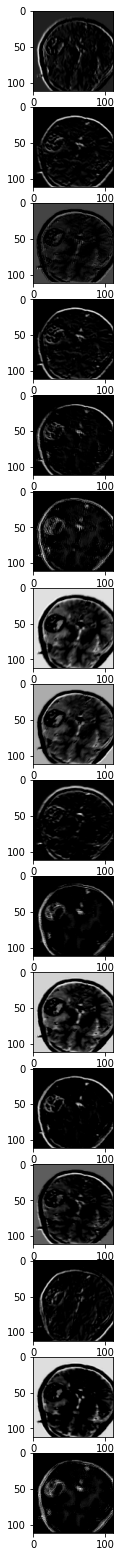

In [115]:
model.relu.register_forward_hook(get_activation('first'))
data, _ = test_data[np.random.randint(len(test_data))]
print(data.shape)
data.unsqueeze_(0)
output = model(data)
print(activation['first'].shape)
act = activation['first'].squeeze()
print(act.shape)
fig, axarr = plt.subplots(act.size(0), figsize = (28,28))
for idx in range(act.size(0)):
    axarr[idx].imshow(act[idx],cmap='gray')

### Last layers

torch.Size([3, 224, 224])
torch.Size([1, 64, 7, 7])
torch.Size([64, 7, 7])


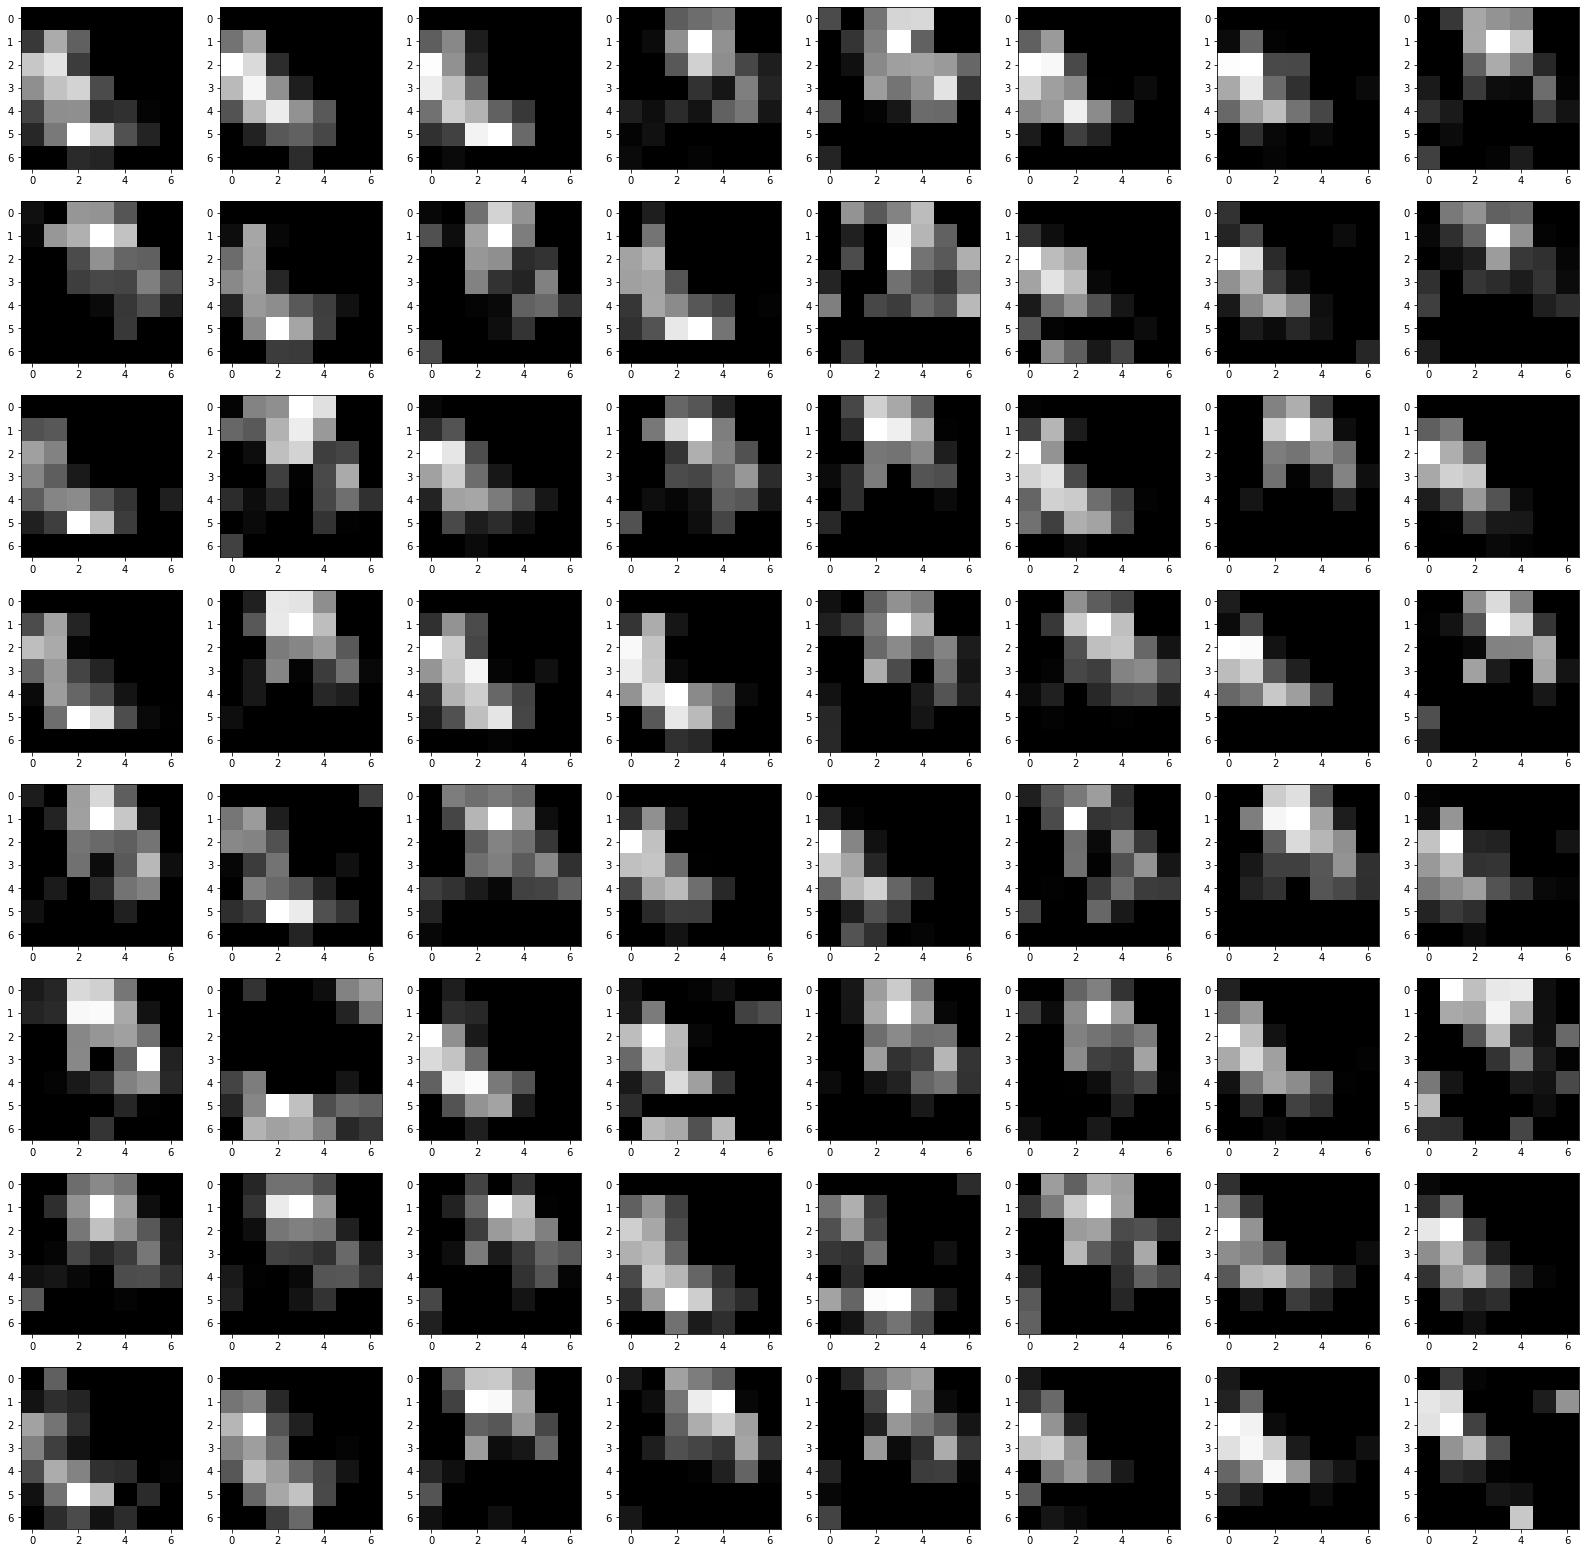

In [116]:

model.res_layer3.relu.register_forward_hook(get_activation('three'))
data, _ = test_data[np.random.randint(len(test_data))]
print(data.shape)
data.unsqueeze_(0)
output = model(data)
print(activation['three'].shape)
act = activation['three'].squeeze()
print(act.shape)
fig, axarr = plt.subplots(8, act.size(0)//8, figsize = (28,28))
for i in range(8):
  for idx in range(act.size(0)//8):
      axarr[i][idx].imshow(act[i*act.size(0)//8 + idx],cmap='gray')


<p dir="rtl" align="right">
همانطور که مشخص است در لایه ابتدایی به ویژگی‌های 
کلی عکس بیشر توجه شده است و مواردی مانند لبه‌ها و ساختارهای کلی‌تر عکس مانند ساختار هندسی بیضوی‌شکل 
مغز مورد توجه بوده است
<br>
در لایه‌های انتهایی ویژگی‌های خاص 
(local)
و پیچیده‌تر مورد توجه بوده است. همانطور که دیده می‌شود 
feature map
های استخراجی در این لایه به دنبال ویژگی‌های خاص‌تر گشته است که فیچرهای معنایی‌تری برای مدل محسوب می‌شوند .
</p>

## Train Without Batchnorm(الف)



In [117]:
model = ResNet(use_batchnorm=False, use_dropout=True)
model.to(device)

#optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=80, gamma=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.1, patience=3, verbose=True
)
criterion = nn.CrossEntropyLoss()


val_loss_min = np.Inf
val_acc_max = 0
for epoch in range(n_epochs):
    train_loss = 0
     
    model.train()
    
    for iteration, (data, label) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data.to(device))
        loss = criterion(output, label.to(device))
        loss.backward()
        optimizer.step()

        
        train_loss += loss.item() * data.shape[0]

        if iteration % print_every == 0:
            is_training = model.training
            val_loss = 0
            model.eval()  
            num_correct = 0
            for data, label in val_loader:
                output = model(data.to(device))
                loss = criterion(output, label.to(device))
                
                val_loss += loss.item() * data.shape[0]
                pred = torch.argmax(output, dim=1)
                num_correct += torch.sum(pred == label.to(device)).item()

            val_loss = val_loss / len(val_loader.sampler)
            val_acc = num_correct / len(val_loader.sampler)

    	
            if val_acc >= val_acc_max and val_loss <= val_loss_min:
                print('\tValidation accuracy increased ({:.6f} --> {:.6f}). Saving model ...'.format(val_acc_max, val_acc))
                torch.save(model.state_dict(), 'model_without_bn.pt')
                val_acc_max = val_acc
                val_loss_min = val_loss

            model.train(mode=is_training)

  
    train_loss = train_loss / len(train_loader.sampler)
    scheduler.step(val_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \t val acc: {:.6f} \t val loss: {:.6f}'.format(epoch+1, train_loss, val_acc, val_loss))

	Validation accuracy increased (0.000000 --> 0.650000). Saving model ...
Epoch: 1 	Training Loss: 0.669738 	 val acc: 0.650000 	 val loss: 0.668266
	Validation accuracy increased (0.650000 --> 0.650000). Saving model ...
Epoch: 2 	Training Loss: 0.658400 	 val acc: 0.650000 	 val loss: 0.633634
	Validation accuracy increased (0.650000 --> 0.650000). Saving model ...
Epoch: 3 	Training Loss: 0.567597 	 val acc: 0.650000 	 val loss: 0.620694
Epoch: 4 	Training Loss: 0.468563 	 val acc: 0.649000 	 val loss: 0.669506
Epoch: 5 	Training Loss: 0.411236 	 val acc: 0.597000 	 val loss: 0.764030
Epoch: 6 	Training Loss: 0.351235 	 val acc: 0.571000 	 val loss: 0.798742
Epoch     7: reducing learning rate of group 0 to 1.0000e-04.
Epoch: 7 	Training Loss: 0.306061 	 val acc: 0.729000 	 val loss: 0.769887
Epoch: 8 	Training Loss: 0.257245 	 val acc: 0.734000 	 val loss: 0.801112
Epoch: 9 	Training Loss: 0.246671 	 val acc: 0.641000 	 val loss: 0.929404
Epoch: 10 	Training Loss: 0.237182 	 val acc

In [118]:
model = ResNet(use_batchnorm=False, use_dropout=True)
model.load_state_dict(torch.load('model_without_bn.pt'))
test_loss = 0.0
num_correct = 0

model.eval()
for data, target in test_loader:
    output = model(data)
    
    pred = torch.argmax(output, dim=1)
    num_correct += torch.sum(pred == target).item()
    
test_acc = num_correct / len(test_loader.sampler)
print('Test Accuracy: {:.2f}%\n'.format(test_acc * 100))

Test Accuracy: 60.00%



<p dir="rtl" align="right"> 
با توجه به اینکه شبکه خیلی عمیق نیست و همچنین از لایه‌های رزیجوال استفاده شده است، پس مشکل 
vanishing gradient
مطرح نیست.
در مقاله‌ای که در کلاس توضیح داده شد، این موضوع مطرح شد که وجود بچ نورمالیزیشن مسیر منتهی به لوکال مینیمم هدف را کوتاه می‌کند. در اینجا هم مشاهده می‌شود که بدون بچ نورمالیزیشن مانند حالت قبل
loss
ترین هم به نقطه مینیمم خود نرسید و احتمالا اگر به مدل زمان بیشتری برای ترینینگ می‌دادیم می‌توانست به لوکال مینیمم برسد
</p>

## Train without Dropout

In [119]:
model = ResNet(use_batchnorm=True, use_dropout=False)
model.to(device)

#optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=80, gamma=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.1, patience=3, verbose=True
)
criterion = nn.CrossEntropyLoss()


val_loss_min = np.Inf
val_acc_max = 0
for epoch in range(n_epochs):
    train_loss = 0
     
    model.train()
    
    for iteration, (data, label) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data.to(device))
        loss = criterion(output, label.to(device))
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * data.shape[0]

        if iteration % print_every == 0:
            is_training = model.training
            val_loss = 0
            model.eval()  
            num_correct = 0
            for data, label in val_loader:
                output = model(data.to(device))
                loss = criterion(output, label.to(device))
                
                val_loss += loss.item() * data.shape[0]
                pred = torch.argmax(output, dim=1)
                num_correct += torch.sum(pred == label.to(device)).item()

            val_loss = val_loss / len(val_loader.sampler)
            val_acc = num_correct / len(val_loader.sampler)

    	
            if val_acc >= val_acc_max and val_loss <= val_loss_min:
                print('\tValidation accuracy increased ({:.6f} --> {:.6f}). Saving model ...'.format(val_acc_max, val_acc))
                torch.save(model.state_dict(), 'model_without_dropout.pt')
                val_acc_max = val_acc
                val_loss_min = val_loss

            model.train(mode=is_training)

  
    train_loss = train_loss / len(train_loader.sampler)
    scheduler.step(val_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \t val acc: {:.6f} \t val loss: {:.6f}'.format(epoch+1, train_loss, val_acc, val_loss))

	Validation accuracy increased (0.000000 --> 0.650000). Saving model ...
Epoch: 1 	Training Loss: 0.518203 	 val acc: 0.650000 	 val loss: 0.683996
	Validation accuracy increased (0.650000 --> 0.748000). Saving model ...
Epoch: 2 	Training Loss: 0.353882 	 val acc: 0.748000 	 val loss: 0.667280
Epoch: 3 	Training Loss: 0.255559 	 val acc: 0.603000 	 val loss: 0.806596
Epoch: 4 	Training Loss: 0.176383 	 val acc: 0.777000 	 val loss: 0.918391
Epoch: 5 	Training Loss: 0.133865 	 val acc: 0.593000 	 val loss: 1.476294
	Validation accuracy increased (0.748000 --> 0.824000). Saving model ...
Epoch: 6 	Training Loss: 0.087794 	 val acc: 0.824000 	 val loss: 0.538095
Epoch: 7 	Training Loss: 0.076510 	 val acc: 0.855000 	 val loss: 0.626740
Epoch: 8 	Training Loss: 0.041926 	 val acc: 0.791000 	 val loss: 0.928609
Epoch: 9 	Training Loss: 0.044928 	 val acc: 0.798000 	 val loss: 0.705155
Epoch    10: reducing learning rate of group 0 to 1.0000e-04.
Epoch: 10 	Training Loss: 0.027015 	 val acc

<p dir="rtl" align="right"> 
همانطور ککه مشاهده می‌شود بدون 
dropout
شبکه بسیار سریع اورفیت می‌شود و لاس سریعا صفر می‌شود
</p>

In [120]:
model = ResNet(use_batchnorm=True, use_dropout=False)
model.load_state_dict(torch.load('model_without_dropout.pt'))
test_loss = 0.0
num_correct = 0

model.eval()
for data, target in test_loader:
    output = model(data)
    
    pred = torch.argmax(output, dim=1)
    num_correct += torch.sum(pred == target).item()
    
test_acc = num_correct / len(test_loader.sampler)
print('Test Accuracy: {:.2f}%\n'.format(test_acc * 100))

Test Accuracy: 83.92%

